In [1]:
import numpy as np
from scipy.linalg import eigh_tridiagonal
from numpy.random import randint, rand
import time

In [2]:
def constr_tridiag(d,od):
    '''
    Constructs (ndim,ndim) symetric tridiagonal array given the diagonal and off-diagonal elements

    d : ndarray, shape (ndim,)
    The diagonal elements of the array.
    e : ndarray, shape (ndim-1,)
    The off-diagonal elements of the array.
    
    returns ndarray, shape (ndim,ndim)
    '''
    
    n = d.size
    tri = np.zeros((n,n))
    for idx1 in range(n-1):
        tri[idx1,idx1] = d[idx1]
        tri[idx1+1,idx1] = od[idx1]
        tri[idx1,idx1+1] = od[idx1]
    tri[-1,-1] = d[-1]
    return tri

In [3]:
def lanczos_eig(A,v0,m):
    '''
    Finds the lowest m eigen values and eigen vectors of a symmetric array

    A : ndarray, shape (ndim, ndim)
    Array to diagnolize.
    v0 : ndarray, shape (ndim,)
    A vector to start the lanczos iteration
    m : scalar
    the dim of the krylov subspace
    
    returns 
    E : ndarray, shape (m,) Eigenvalues
    W : ndarray, shape (ndim, m) Eigenvectors
    '''

    n = v0.size
    Q = np.zeros((m,n))
    
    v = np.zeros_like(v0)
    r = np.zeros_like(v0) # v1
    
    b = np.zeros((m,))
    a = np.zeros((m,))
    
    v0 = v0 / np.linalg.norm(v0)
    Q[0,:] = v0
    
    r = A @ v0
    a[0] = v0 @ r
    r = r - a[0]*v0
    b[0] = np.linalg.norm(r)
    
    error = np.finfo(np.float64).eps

    for i in range(1,m,1):
        v = Q[i-1,:]

        Q[i,:] = r / b[i-1]

        r = A @ Q[i,:] # |n>

        r = r - b[i-1]*v

        a[i] = (Q[i,:] @ r) # real?
        r = r - a[i]*Q[i,:]

        b[i] = np.linalg.norm(r)
        
        if b[i] < error:
            m = i
            print('smaller space found',m)
            break

    E,V = eigh_tridiagonal(a[:m],b[:m-1])
    Q = Q[:m]
    W = (Q.T @ V)
#     tri = constr_tridiag(a[:m],b[:m-1])
    return E, W


In [57]:
def rand_herm(size,sparsity):
    mat = np.zeros(size*size)
    nonzero_num = int(size*size*sparsity/2)
    nonzero_idx = randint(0, size**2, size=nonzero_num)
    mat[nonzero_idx] = rand(nonzero_num)
    mat = mat.reshape(size, size)
    mat = mat + mat.T
    return mat

In [65]:
rand_herm(4,0.5)

array([[0.49290476, 0.02080339, 0.        , 0.        ],
       [0.02080339, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.46091116]])

In [5]:

# herm_mat = rand_herm(10,0.2)

# x = rand(10)
# print(np.allclose(herm_mat,herm_mat.T),np.mean(herm_mat != 0))

# E, W = lanczos_eig(herm_mat,x,7)
# print(W[:,0])
# print(np.linalg.eigh(herm_mat)[1][:,0])
# print(W[:,0] @ np.linalg.eigh(herm_mat)[1][:,0])

In [6]:
def timeon(size, sparsity, k):
    mat = rand_herm(size, sparsity)
    
    t0 = time.time()
    
    x = rand(size)
    _, W1 = lanczos_eig(mat,x,k)
    eiglanc = W1[:,0]
    
    t1 = time.time()
    
    _, W2 = np.linalg.eigh(mat)
    eigres = W2[:,0]

    t2 = time.time()
    
    fidelity = np.abs(eigres @ eiglanc)
    
    tlanc = t1 - t0
    teigh = t2 - t1
    
    return tlanc, teigh, (teigh - tlanc) > 0, fidelity
    

In [7]:
def avg_run(repeats, size, sparsity, k):
    tlanc_list = []
    teigh_list = []
    fidelity_list = []
    for idx in range(repeats):
        tlanc, teigh, _ , fidelity = timeon(size, sparsity, k)
        fidelity_list.append(fidelity)
        tlanc_list.append(tlanc)
        teigh_list.append(teigh)
    
    return np.mean(tlanc_list), np.mean(teigh_list), np.mean(fidelity_list)
    

In [9]:
# tlanc_avg, teigh_avg, fidelity_avg = avg_run(100, 1000, 0.2, 40)

In [59]:
asetofres = []
for size_idx in range(300,1500,20):
    asetofres.append(avg_run(100, size_idx, 0.3, min(50+int(10*size_idx/1500),size_idx//10)))

In [62]:
# np.save('lanc_compv2.npy', np.array(asetofres))

In [53]:
asetofres2 = np.load('lanc_comp.npy')

In [9]:
from matplotlib import pyplot as plt

In [49]:
plt.rcParams['axes.facecolor']=(242/255, 243/255, 248/255)
# plt.rcParams['savefig.facecolor']='red'

In [41]:
darkpurp = (48/255, 19/255, 94/255)
background2 = (242/255, 243/255, 248/255)

256

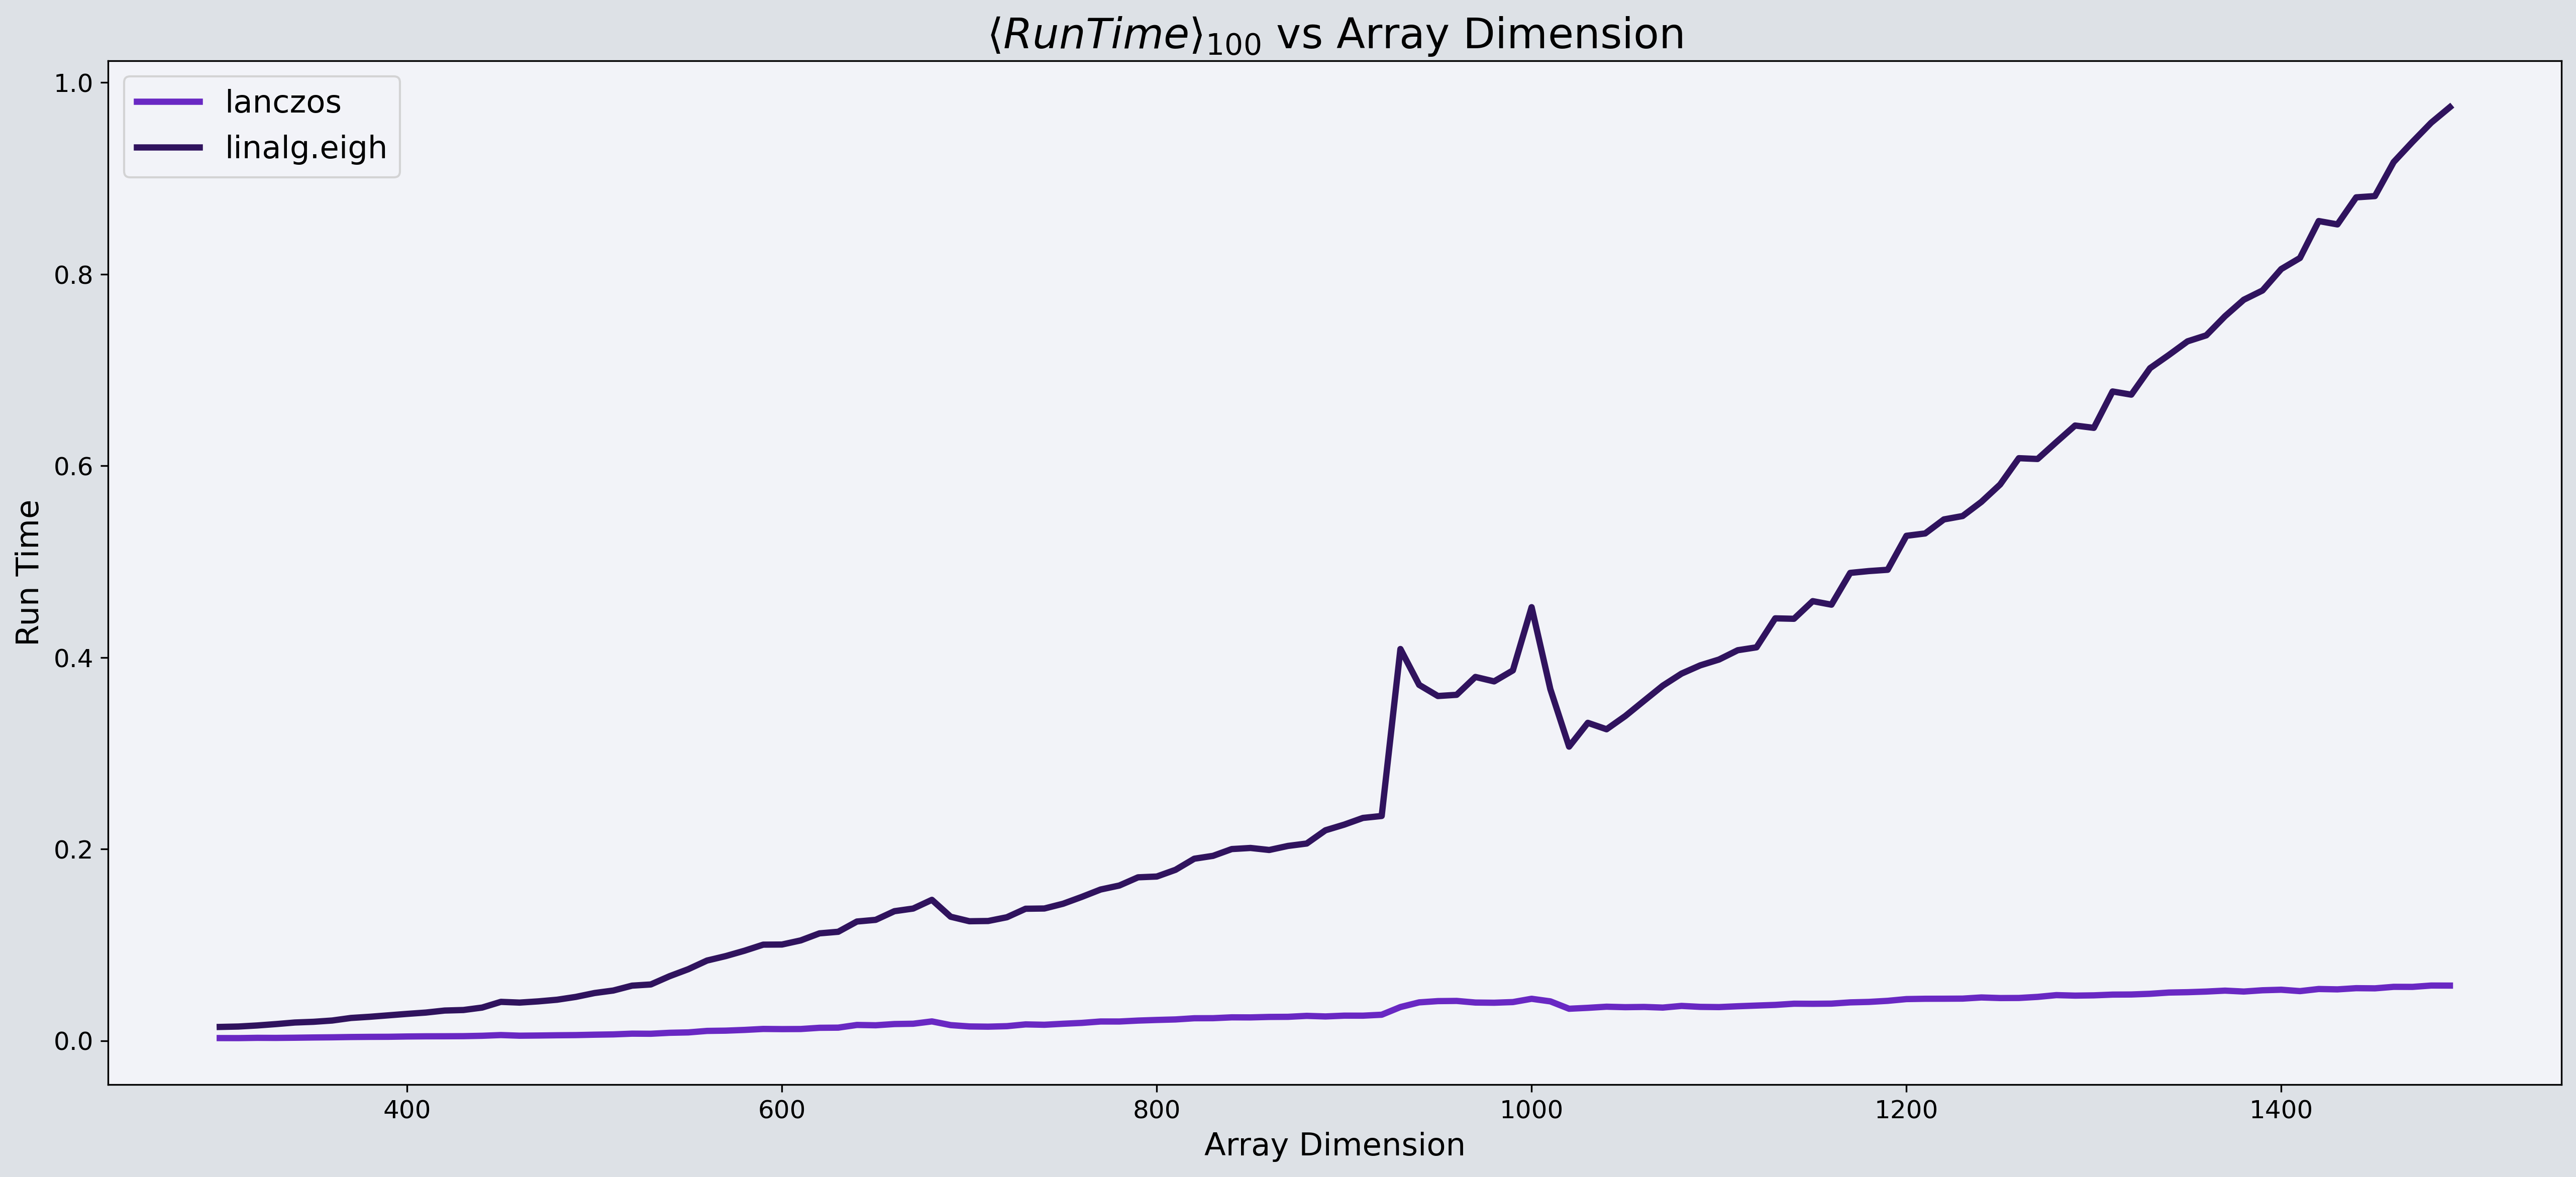

In [54]:
plt.figure(figsize=(21,9),dpi=300,facecolor=(221/255, 225/255, 230/255))
plt.plot(range(300,1500,10), np.array(asetofres2)[:,0],'-o', markersize=1, linewidth=3,label='lanczos',color=(105/255, 40/255, 195/255))
plt.plot(range(300,1500,10), np.array(asetofres2)[:,1],'-o', markersize=1, linewidth=3,label='linalg.eigh',color=(48/255, 19/255, 94/255))
plt.xlabel('Array Dimension',fontsize=15)
plt.ylabel('Run Time',fontsize=15)
plt.title('$ \langle Run Time \\rangle_{100} $ vs Array Dimension',fontsize=20)
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('batmat_lanc-vs-eigh.png',bbox_inches='tight')

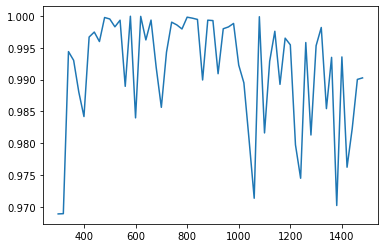

In [38]:
plt.plot(range(300,1500,20), np.array(asetofres2)[:,2])


In [39]:
np.mean(np.array(asetofres2)[:,2])

0.9914649231708914

In [57]:
for size_idx in range(100,1500,100):
    print(size_idx, min(50+int(10*size_idx/1100),size_idx//10))

100 10
200 20
300 30
400 40
500 50
600 55
700 56
800 57
900 58
1000 59
1100 60
1200 60
1300 61
1400 62
